# Simpley Demonstrate the matrix-based B-purification w/ a single realization

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
PREFIX = 'observed'
nside = 64

In [3]:
Npix = hp.nside2npix(nside)
lmax = 3 * nside - 1
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
print('nside:{:}, Npix:{:}, res:{:.1f} deg, sigmab:{:.1f} deg, fwhm:{:.1f} deg'.
      format(nside, Npix, np.rad2deg(hp.nside2resol(nside)), np.rad2deg(sigmab), np.rad2deg(fwhm)))

nside:64, Npix:49152, res:0.9 deg, sigmab:0.9 deg, fwhm:2.2 deg


In [24]:
prefix = 'scan_masked'
mask = np.array(hp.read_map('{:}_nside{:03d}.fits'.format(prefix,nside)), dtype=bool)
#hp.mollview(mask, title='Used mask, ring')
unseen = ~mask
nums = np.sum(mask)
fsky = nums / mask.shape[0]
fsky

0.15519205729166666

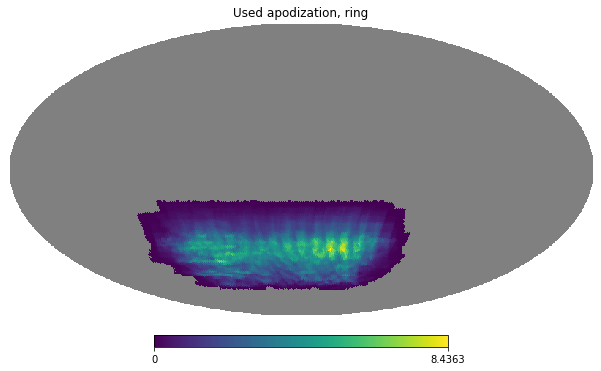

In [26]:
prefix = 'scan_masked_apodization'
Z = apodization = np.array(hp.read_map('{:}_nside{:03d}.fits'.format(prefix,nside)))
hp.mollview(np.ma.masked_array(apodization, mask=~mask, fill_value=hp.UNSEEN), title='Used apodization, ring')

## prepare camb

In [6]:
!pip3 install camb --user

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
import camb

In [8]:
%%time
pars = camb.CAMBparams()
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0.2)
pars.set_for_lmax(4000, lens_potential_accuracy=1)
pars.set_accuracy(AccuracyBoost=1)
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.WantTensors = True
pars.max_l_tensor = 1600
pars.max_eta_k_tensor = 3200
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
print(powers.keys())

dict_keys(['total', 'unlensed_scalar', 'unlensed_total', 'lensed_scalar', 'tensor', 'lens_potential'])
CPU times: user 2min 4s, sys: 845 ms, total: 2min 5s
Wall time: 1.6 s


In [9]:
def dl2cl(l,dl):
    return dl/l/(l+1)*2*np.pi

def cl2dl(l,cl):
    return l*(l+1)*cl/2/np.pi

def get_cls(key, teb='teb'):
    #total
    #unlensed_scalar
    #unlensed_total
    #lensed_scalar
    #tensor
    #ens_potential
    Dls = powers[key]
    ell = np.arange(Dls.shape[0])
    ell[0] = 1.
    cltt, clee, clbb, clte = dl2cl(ell, Dls.T)
    if teb == 'te':
        clbb = np.zeros_like(cltt)
    elif teb == 'tb':
        clte = clee = np.zeros_like(cltt)

    cltb = cleb = np.zeros_like(cltt)
    # a list of cl’s (TT, EE, BB, TE, EB, TB for polarized input map)
    return cltt,clee,clbb,clte,cleb,cltb

## prepare purification

In [10]:
import scipy

In [11]:
%%time
idx_n2r = hp.ring2nest(nside,np.arange(Npix)[mask])
mask3 = np.hstack((idx_n2r + Npix, idx_n2r + 2*Npix))
obs_matrix = scipy.sparse.load_npz('toast_telescope_all_time_all_obs_matrix.npz')[mask3][:,mask3]

CPU times: user 53.7 s, sys: 3.42 s, total: 57.1 s
Wall time: 57.2 s


In [12]:
%%time
from scipy.sparse import diags
ZZ = diags(np.hstack((Z[mask],Z[mask])))
obs_matrix_apo = ZZ @ obs_matrix

CPU times: user 63.7 ms, sys: 19.8 ms, total: 83.5 ms
Wall time: 82.5 ms


In [13]:
%%time
f = np.load('{:}_eigen_spectrum_nside{:03d}.npz'.format(PREFIX,nside))
eigvals = f['eigvals']
norm_eigvecs = f['norm_eigvecs']

CPU times: user 1.35 s, sys: 521 ms, total: 1.87 s
Wall time: 1.87 s


In [14]:
#lens = np.searchsorted(eigvals > 0.98, True)
lens = 2 * nums //4
2 * nums, lens

(15256, 4388)

In [15]:
%%time
v = norm_eigvecs[:,-lens:]
Pib = Pi = np.tensordot(v,v,axes=((1,),(1,)))

CPU times: user 44.1 s, sys: 28.3 s, total: 1min 12s
Wall time: 2.21 s


## demonstrate the purification in map

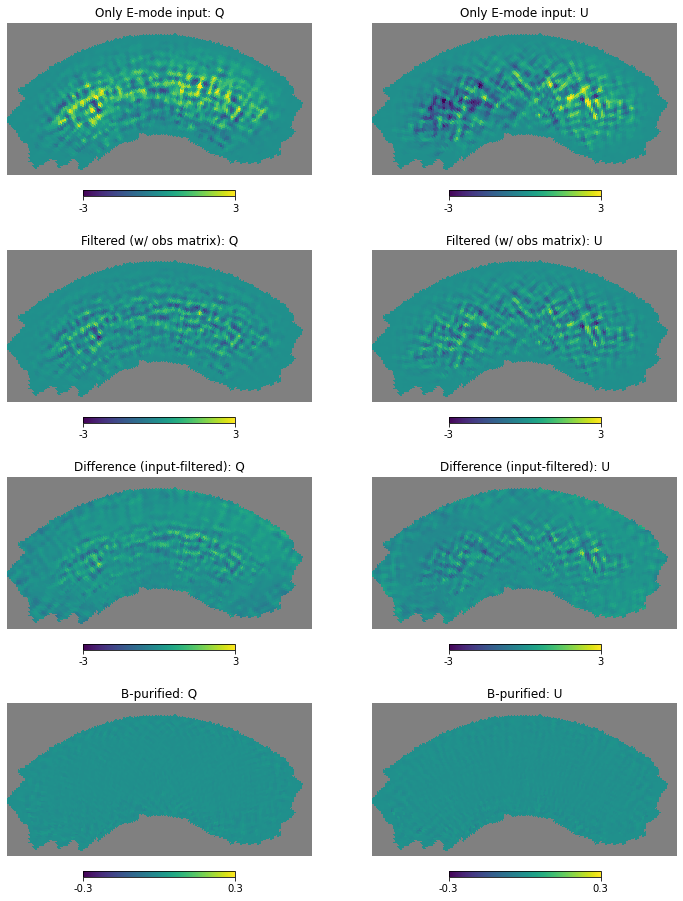

In [35]:
np.random.seed(0)
key = 'lensed_scalar'
label = "Only E-mode"
Cls = Cls_te = get_cls(key, teb='te')
l = ls = np.arange(len(Cls[0]))
CLs = CLs_te = Cls * np.exp(-l*(l+1)*sigmab**2)
Dls = Dls_te = cl2dl(l,Cls)
DLs = DLs_te = cl2dl(l,CLs)
map0 = hp.synfast(Cls, nside, sigma=sigmab, pol=True, new=True)

m = np.zeros(shape=(3,Npix))
Rm = np.zeros(shape=(3,Npix))
pRm = np.zeros(shape=(3,Npix))

m[:,mask] = map0[:,mask]
Rm[1:,mask] = (obs_matrix_apo @ m[1:,mask].ravel()).reshape((2,-1))
pRm[1:,mask] = (Pib @ Rm[1:,mask].ravel()).reshape((2,-1))
Rm_m = m - Rm

RA0, Dec0 = 15, -40
lonra = [-75,75]
latra = [-45,30]
vmax = 3
fig,ax = plt.subplots(4,2, figsize=(12,16))
for iflavor,flavor in enumerate(('Q','U')):
    plt.axes(ax[0][iflavor])
    hp.cartview(np.ma.masked_array(Z*m[iflavor+1], mask=~mask, fill_value=hp.UNSEEN),
                rot=(RA0, Dec0, 0), lonra=lonra, latra=latra, max=vmax, min=-vmax, hold=True, xsize=640, title="{:} input: {:}".format(label, flavor))
    
    plt.axes(ax[1][iflavor])
    hp.cartview(np.ma.masked_array(Rm[iflavor+1], mask=~mask, fill_value=hp.UNSEEN),
                rot=(RA0, Dec0, 0), lonra=lonra, latra=latra, max=vmax, min=-vmax, hold=True, xsize=640, title="Filtered (w/ obs matrix): {:}".format(flavor))
    
    plt.axes(ax[2][iflavor])
    hp.cartview(np.ma.masked_array(Rm_m[iflavor+1], mask=~mask, fill_value=hp.UNSEEN),
                rot=(RA0, Dec0, 0), lonra=lonra, latra=latra, max=vmax, min=-vmax, hold=True, xsize=640, title="Difference (input-filtered): {:}".format(flavor))

    plt.axes(ax[3][iflavor])
    hp.cartview(np.ma.masked_array(pRm[iflavor+1], mask=~mask, fill_value=hp.UNSEEN),
                rot=(RA0, Dec0, 0), lonra=lonra, latra=latra, max=vmax/10, min=-vmax/10, hold=True, xsize=640, title="B-purified: {:}".format(flavor))

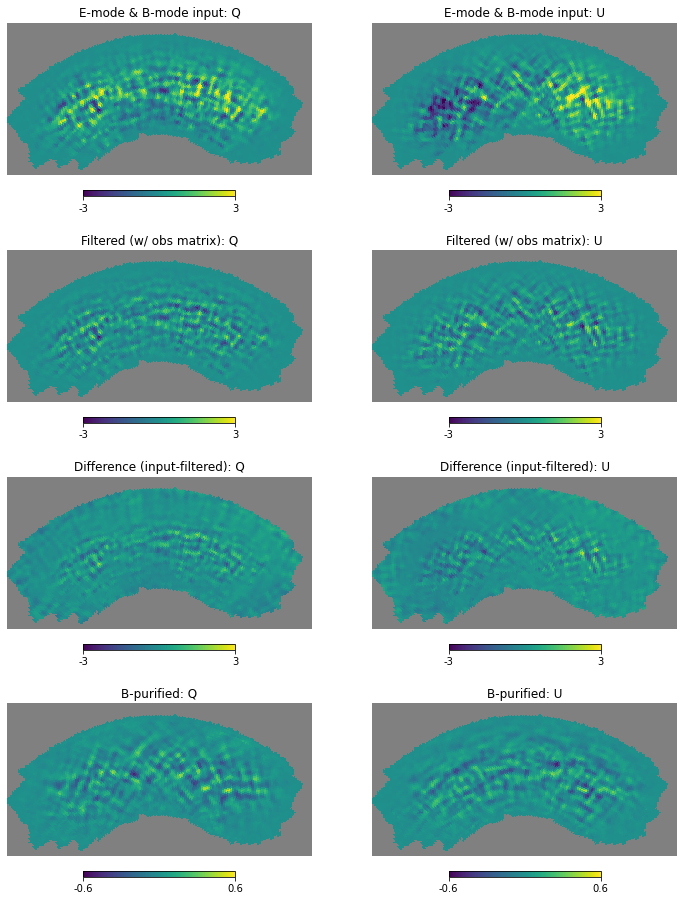

In [36]:
np.random.seed(0)
key = 'total'
label = "E-mode & B-mode"
Cls = Cls_te = get_cls(key, teb='teb')
l = ls = np.arange(len(Cls[0]))
CLs = CLs_teb = Cls * np.exp(-l*(l+1)*sigmab**2)
Dls = Dls_teb = cl2dl(l,Cls)
DLs = DLs_teb = cl2dl(l,CLs)
map0 = hp.synfast(Cls, nside, sigma=sigmab, pol=True, new=True)

m = np.zeros(shape=(3,Npix))
Rm = np.zeros(shape=(3,Npix))
pRm = np.zeros(shape=(3,Npix))

m[:,mask] = map0[:,mask]
Rm[1:,mask] = (obs_matrix_apo @ m[1:,mask].ravel()).reshape((2,-1))
pRm[1:,mask] = (Pib @ Rm[1:,mask].ravel()).reshape((2,-1))
Rm_m = m - Rm

RA0, Dec0 = 15, -40
lonra = [-75,75]
latra = [-45,30]
vmax = 3
fig,ax = plt.subplots(4,2, figsize=(12,16))
for iflavor,flavor in enumerate(('Q','U')):
    plt.axes(ax[0][iflavor])
    hp.cartview(np.ma.masked_array(Z*m[iflavor+1], mask=~mask, fill_value=hp.UNSEEN),
                rot=(RA0, Dec0, 0), lonra=lonra, latra=latra, max=vmax, min=-vmax, hold=True, xsize=640, title="{:} input: {:}".format(label, flavor))
    
    plt.axes(ax[1][iflavor])
    hp.cartview(np.ma.masked_array(Rm[iflavor+1], mask=~mask, fill_value=hp.UNSEEN),
                rot=(RA0, Dec0, 0), lonra=lonra, latra=latra, max=vmax, min=-vmax, hold=True, xsize=640, title="Filtered (w/ obs matrix): {:}".format(flavor))
    
    plt.axes(ax[2][iflavor])
    hp.cartview(np.ma.masked_array(Rm_m[iflavor+1], mask=~mask, fill_value=hp.UNSEEN),
                rot=(RA0, Dec0, 0), lonra=lonra, latra=latra, max=vmax, min=-vmax, hold=True, xsize=640, title="Difference (input-filtered): {:}".format(flavor))

    plt.axes(ax[3][iflavor])
    hp.cartview(np.ma.masked_array(pRm[iflavor+1], mask=~mask, fill_value=hp.UNSEEN),
                rot=(RA0, Dec0, 0), lonra=lonra, latra=latra, max=vmax/5, min=-vmax/5, hold=True, xsize=640, title="B-purified: {:}".format(flavor))

## prepare nmt

In [18]:
!pip3 install pymaster --user

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [19]:
import pymaster as nmt

def maps2pseudospectra(iqu_map, apod, has_apodized=False, do_pure=False):
    if has_apodized:
        amask = apod > 0.
        tmp = np.zeros_like(iqu_map)
        tmp[:,amask] = iqu_map[:,amask]/apod[amask]
        I,Q,U = tmp
    else:
        I,Q,U = iqu_map
        
    f0 = nmt.NmtField(apod, [I,])
    (cltt,) = nmt.compute_coupled_cell(f0, f0)

    f2 = nmt.NmtField(apod, [Q, U], purify_e=False, purify_b=do_pure)
    clee,cleb,clbe,clbb = nmt.compute_coupled_cell(f2, f2)
    
    clte,cltb = nmt.compute_coupled_cell(f0, f2)

    return cltt,clee,clbb,clte,0.5*(cleb+clbe),cltb,np.arange(len(cltt))

## demonstrate the purification in pseudo-Cl

In [20]:
cls0 = hp.anafast(map0, pol=True)
cls0_mask = hp.anafast(map0*mask, pol=True) / fsky

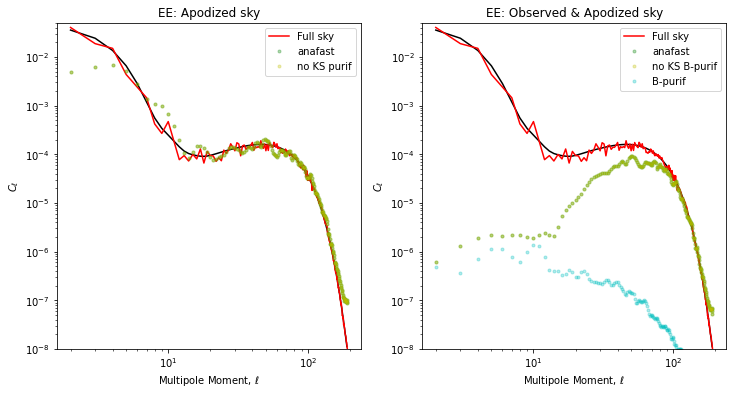

In [21]:
idx = 1
ymin = 1e-8
ymax = 5e-2
fig,axes = plt.subplots(1,2, figsize=(12,6))
##########################################################
plt.axes(axes[0])
title = 'EE: Apodized sky'

plt.plot(ls[2:lmax], CLs_teb[idx][2:lmax], 'k-')
# input map
cls = cls0
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'r-', label='Full sky')

# masked
cls = hp.anafast(map0*apodization, pol=True)
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'g.', alpha=0.3, label="anafast")

# no KS
cls = maps2pseudospectra(map0, apodization, do_pure=False)
l = cls[-1]
plt.loglog(l[2:],cls[idx][2:], 'y.', alpha=0.3, label='no KS purif')

plt.title(title)
plt.ylabel(r"$C_\ell$")
plt.xlabel(r"Multipole Moment, $\ell$")
plt.ylim(ymin,ymax)
plt.legend()

##########################################################
plt.axes(axes[1])
title = 'EE: Observed & Apodized sky'

plt.plot(ls[2:lmax], CLs_teb[idx][2:lmax], 'k-')
# input map
cls = cls0
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'r-', label='Full sky')

# masked
cls = hp.anafast(Rm, pol=True)
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'g.', alpha=0.3, label="anafast")

# no KS
cls = maps2pseudospectra(Rm, apodization, has_apodized=True, do_pure=False)
l = cls[-1]
plt.loglog(l[2:],cls[idx][2:], 'y.', alpha=0.3, label='no KS B-purif')

cls = hp.anafast(pRm, pol=True)
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'c.', alpha=0.3, label="B-purif")

plt.title(title)
plt.ylabel(r"$C_\ell$")
plt.xlabel(r"Multipole Moment, $\ell$")
plt.ylim(ymin,ymax)
plt.legend()

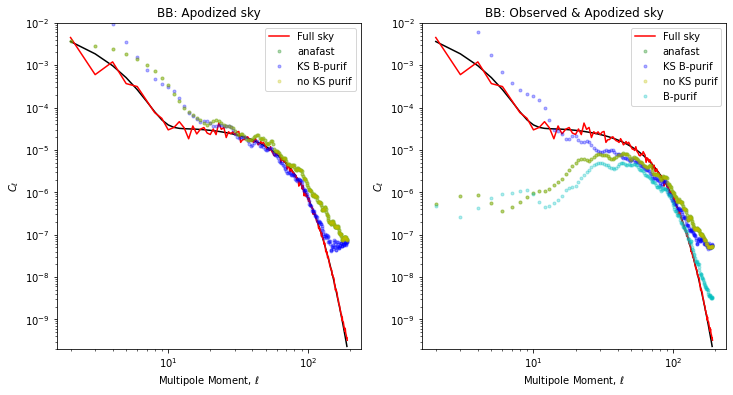

In [22]:
idx = 2
ymin = 2e-10
ymax = 1e-2
fig,axes = plt.subplots(1,2, figsize=(12,6))
##########################################################
plt.axes(axes[0])
title = 'BB: Apodized sky'

plt.plot(ls[2:lmax], CLs_teb[idx][2:lmax], 'k-')
# input map
cls = cls0
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'r-', label='Full sky')

# masked
cls = hp.anafast(map0*apodization, pol=True)
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'g.', alpha=0.3, label="anafast")

# KS
cls = maps2pseudospectra(map0, apodization, do_pure=True)
l = cls[-1]
plt.loglog(l[2:],cls[idx][2:], 'b.', alpha=0.3, label='KS B-purif')

# no KS
cls = maps2pseudospectra(map0, apodization, do_pure=False)
l = cls[-1]
plt.loglog(l[2:],cls[idx][2:], 'y.', alpha=0.3, label='no KS purif')

plt.title(title)
plt.ylabel(r"$C_\ell$")
plt.xlabel(r"Multipole Moment, $\ell$")
plt.ylim(ymin,ymax)
plt.legend()

##########################################################
plt.axes(axes[1])
title = 'BB: Observed & Apodized sky'

plt.plot(ls[2:lmax], CLs_teb[idx][2:lmax], 'k-')
# input map
cls = cls0
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'r-', label='Full sky')

# masked
cls = hp.anafast(Rm, pol=True)
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'g.', alpha=0.3, label="anafast")

# KS
cls = maps2pseudospectra(Rm, apodization, has_apodized=True, do_pure=True)
l = cls[-1]
plt.loglog(l[2:],cls[idx][2:], 'b.', alpha=0.3, label='KS B-purif')

# no KS
cls = maps2pseudospectra(Rm, apodization, has_apodized=True, do_pure=False)
l = cls[-1]
plt.loglog(l[2:],cls[idx][2:], 'y.', alpha=0.3, label='no KS purif')

cls = hp.anafast(pRm, pol=True)
l = np.arange(cls.shape[1])
plt.loglog(l[2:],cls[idx][2:], 'c.', alpha=0.3, label="B-purif")

plt.title(title)
plt.ylabel(r"$C_\ell$")
plt.xlabel(r"Multipole Moment, $\ell$")
plt.ylim(ymin,ymax)
plt.legend()